# PFIA tutorial on Early Classification of Time Series

This notebook gives a gentle introduction to the Early Classification of Time Series (ECTS) task.

It is based on the `ml_edm` open-source python package, developped relatively to the taxonomy proposed in the recent [survey paper](https://arxiv.org/abs/2406.18332).

The packages is modular, with :
 
 - A module dedicated to Classification stage, the implemented strategy in the library corresponds to the simple set of independently trained classifiers under the name `ClassifiersCollection`.
 - Another module for triggering models, 8 state-of-the-art trigger models implementations can be found in the package.
     - `ProbabilityThreshold`: triggers a prediction if the estimated probability of the likeliest prediction exceeds some threshold, found by grid search
     - `StoppingRule`: uses a trigger function based on a linear combination of confidence estimates and a delay measure linear on time
     - `EconomyGamma`: triggers a decision if the predicted cost expectation is the lowest at time $t$ when compared with the expected cost for all future time steps.
     - `TEASER`: employs a trigger module consisting of a collection of $T$ One Class SVM learned over the training set in order to isolate good predictions from bad ones. A prediction is triggered once $\nu$ consecutive predictions have been classified as `good' by these OneClass SVM.
     - `ECEC`: defines a confidence measure, based on the aggregated confidence of the predictions up to time $t$, and triggers a prediction if it exceeds a threshold, tuned by explicit grid-search.
     - `CALIMERA`: triggers a decision when a regressor model which predicts the difference between the current observed cost and the minimum cost in the future is negative.
     - `ECDIRE`: determines *safe* timestamps, based on classifier performance, from which predictions about possible classes can be made. Predictions cannot be triggered if those timestamps have not been reached. In addition, the difference between the two highest predicted probabilities must also exceed a certain threshold.
     - `EDSC`: trigger a prediction as soon as one discriminative shapelet match the currently observed time series.

## Preamble : Import and Installation

In [1]:
%pip install git+https://github.com/ML-EDM/ml_edm.git
%pip install matplotlib==3.7.1

  Cloning https://github.com/ML-EDM/ml_edm.git to /tmp/pip-req-build-6kgvbggx
  Running command git clone --filter=blob:none --quiet https://github.com/ML-EDM/ml_edm.git /tmp/pip-req-build-6kgvbggx
  Resolved https://github.com/ML-EDM/ml_edm.git to commit c60137a58f0131e0d9b153e9dfc0030584f11539
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 14.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Load time series data 

The first step is to load some appropriate time series data.

To do so, we'll use the `aeon` datasets API.

The *SmoothSubspace* datasets is a three class synthetic datasets, containing time series of length 15. 

In [3]:
from aeon.datasets import load_classification
from sklearn.preprocessing import LabelEncoder

X, y, meta = load_classification(name="SmoothSubspace")
# Others datasets include "GunPoint", "HouseTwenty", "Chinatown", "MelbournePedestrian"
# see https://www.timeseriesclassification.com/dataset.php for a complete list of available datasets

le_ = LabelEncoder()
y = le_.fit_transform(y)

print(X.shape)

# we'll only work with univariate data 
X = X.squeeze()
n_samples, max_T = X.shape

(300, 1, 15)


Let's now vizualise how our time series datasets looks like :

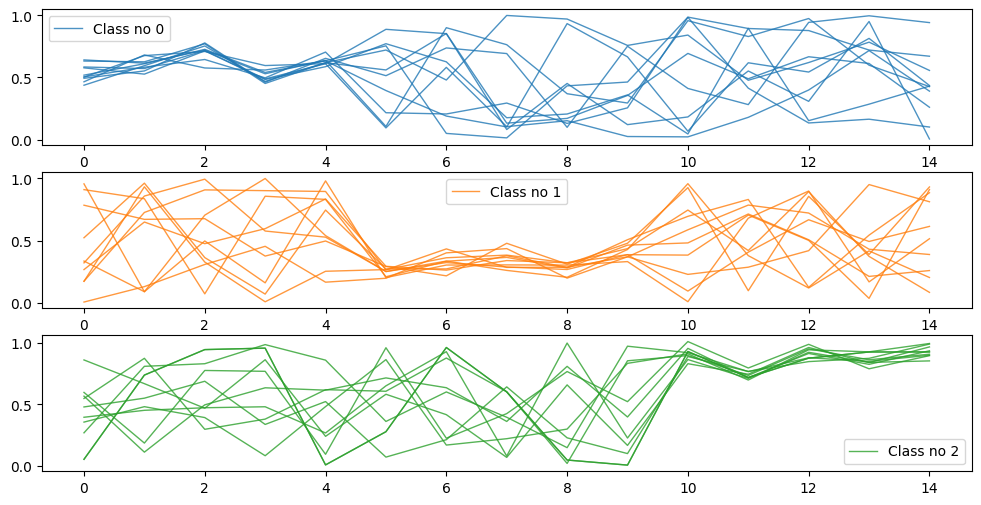

In [4]:
import itertools

classes, counts = np.unique(y, return_counts=True)
colors = itertools.cycle(plt.cm.tab10.colors)

# vizualisation of the dataset
fig, axes = plt.subplots(nrows=len(classes), ncols=1, figsize=(12,6))

for i, cls in enumerate(classes):
    rd_idx = np.random.choice(np.where(y==cls)[0], size=10)
    c = next(colors)
    for j, idx in enumerate(rd_idx):
        axes[i].plot(X[idx].squeeze(), color=c, alpha=0.8, lw=1,
                     label=f"Class no {cls}" if j == 0 else "")
        if j == 0:
            axes[i].legend()
plt.show()

## Building your first `EarlyClassifier`


This first part of the tutorial will give you a stepb-y-step minimalist introduction to the `ml_edm` library.

### Step 1 : Define the `CostMatrices` : 


The first very important compenent of our pipeline is the `CostMatrices` object. It basically defines how much our ECTS algorithm will have to pay with respect to its decisions.

This will eventually serve as the ground truth, over which ECTS algorithms will be evaluated.

In [5]:
from ml_edm.cost_matrices import CostMatrices
from ml_edm.utils import check_timestamps

sampling_ratio = 0.05
timestamps = [int(max_T * (sampling_ratio * i)) for i in range(1, int(1/sampling_ratio)+1)]
# delete potential duplicates, O's 
timestamps = check_timestamps(timestamps)

ALPHA = 0.5
cost_matrices = CostMatrices(timestamps=timestamps, n_classes=len(classes), alpha=ALPHA)

/home/arenault/anaconda3/envs/ml_edm/lib/python3.9/site-packages/ml_edm/utils.py:110: UserWarning: Removed duplicates in argument 'timestamps'.
  warn("Removed duplicates in argument 'timestamps'.")
/home/arenault/anaconda3/envs/ml_edm/lib/python3.9/site-packages/ml_edm/utils.py:114: UserWarning: Removed 0 from 'timestamps', first valid timestamps is usually 1.
  warn("Removed 0 from 'timestamps', first valid timestamps is usually 1.")
/home/arenault/anaconda3/envs/ml_edm/lib/python3.9/site-packages/ml_edm/cost_matrices.py:67: UserWarning: No misclassification cost defined, using default binary set up,bad classification cost =  1, 0 otherwise
  warn("No misclassification cost defined, using default binary set up,"
/home/arenault/anaconda3/envs/ml_edm/lib/python3.9/site-packages/ml_edm/cost_matrices.py:83: UserWarning: No delay cost defined, using default linear delay function
  warn("No delay cost defined, using default linear delay function")


By default, when no cost is defined (cf *warnings* above):

\begin{align}
C_m(\hat{y}|y) = \alpha \times \mathbb{1}(\hat{y} \neq y) \\
C_d(t) = (1 - \alpha) \times \frac{t}{T}
\end{align}

Of course, in real-life setups it will be of first importance to correctly define your costs functions, the default setting being unlikely well suited for most of use-cases.

The $\alpha$ parameter controls the balance between the two type of costs. $\alpha = 0.5$ corresponds to a equal importance between the cost of making a mistake and to wait for the end of the series to be unveil. 

In [6]:
#Alternatively, it's equivalent to define `CostMatrices` this way : 
def delay(t):
    return t/max_T

cost_matrices = CostMatrices(
    misclf_cost=1-np.eye(len(classes)),
    delay_cost=delay,
    timestamps=timestamps, 
    n_classes=len(classes), 
    alpha=ALPHA
)

### Step 2 : Define a Classification strategy 


Now, we'll be interested in the classification stage : here, the goal is to build an estimator, whose capable of provide us predictions based on a time series, whatever it's length. 

The most common (and rather simple) practice consists in defining a list of classifiers, each of which is assigned to one specific timestamp.

**NOTE** : When the considered time series are very long and to keep computation reasonable, one usually selects a subset of timestamps (typically 20, i.e. one classifier for every 5% of the series).

But first, let's split our data as usual between train/test. The train set, being itself splitted between classification/trigger sets.

In [7]:
from sklearn.model_selection import train_test_split

# Let's split our dataset between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

# Another split in our training set beteween classification and trigger data
X_classif, X_trigger, y_classif, y_trigger = train_test_split(X, y, test_size=0.4, random_state=44)

The implementation of the `ClassifiersCollection` takes as input a `base_classifier`, which can be any of the `sklearn` compatible estimator, as long as it has a callable `predict_proba` method.

For our part, le'ts define a rather basic pipeline, including the following steps :

- A feature engineering step, with the `SplineTransformer` class, that will help us having time-related features. (see [Scikit-learn documentation](https://scikit-learn.org/1.5/modules/preprocessing.html#spline-transformer))
- Then, a simple and efficient linear model is learned, using the `RidgeClassifierCV`.
- Finally, a calibration step, using isotonic regression, is added : it allows one to correctly compare classifiers outputs with one another. \
  (Additionaly, it will give our pipeline a `predict_proba` method, which is not included in the `RidgeClassifierCV` implementation.)

In [8]:
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline
from ml_edm.classification.classifiers_collection import ClassifiersCollection

clf = make_pipeline(
    SplineTransformer(),
    CalibratedClassifierCV(RidgeClassifierCV(), method="isotonic")
)

collection_clf = ClassifiersCollection(
    base_classifier=clf,
    timestamps=timestamps
)
collection_clf.fit(X_classif, y_classif)

/home/arenault/anaconda3/envs/ml_edm/lib/python3.9/site-packages/ml_edm/classification/_base.py:35: UserWarning: No min_length procided, using a minimum length of 1 by default
  warn("No min_length procided, using a minimum length of 1 by default")


ClassifiersCollection(base_classifier=Pipeline(steps=[('splinetransformer',
                                                       SplineTransformer()),
                                                      ('calibratedclassifiercv',
                                                       CalibratedClassifierCV(estimator=RidgeClassifierCV(),
                                                                              method='isotonic'))]),
                      classifiers=[CalibratedClassifierCV(cv='prefit',
                                                          estimator=Pipeline(steps=[('splinetransformer',
                                                                                     SplineTransformer()),
                                                                                    ('calibratedclassifiercv',
                                                                                     CalibratedC...
                                                                                     CalibratedClassifierCV(estimator=RidgeClassifierCV(),
                                                                                                            method='isotonic'))])),
                                   CalibratedClassifierCV(cv='prefit',
                                                          estimator=Pipeline(steps=[('splinetransformer',
                                                                                     SplineTransformer()),
                                                                                    ('calibratedclassifiercv',
                                                                                     CalibratedClassifierCV(estimator=RidgeClassifierCV(),
                                                                                                            method='isotonic'))]))],
                      min_length=1,
                      timestamps=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]))

As sanity check, one can check that the classification performances is an increasing function of time.

**NOTE**: Even though ECTS models should be robust to noisy ending series, we prefer, for pedagogical reasons, to keep a simple configuration in which information gain is obvious depending on time. 

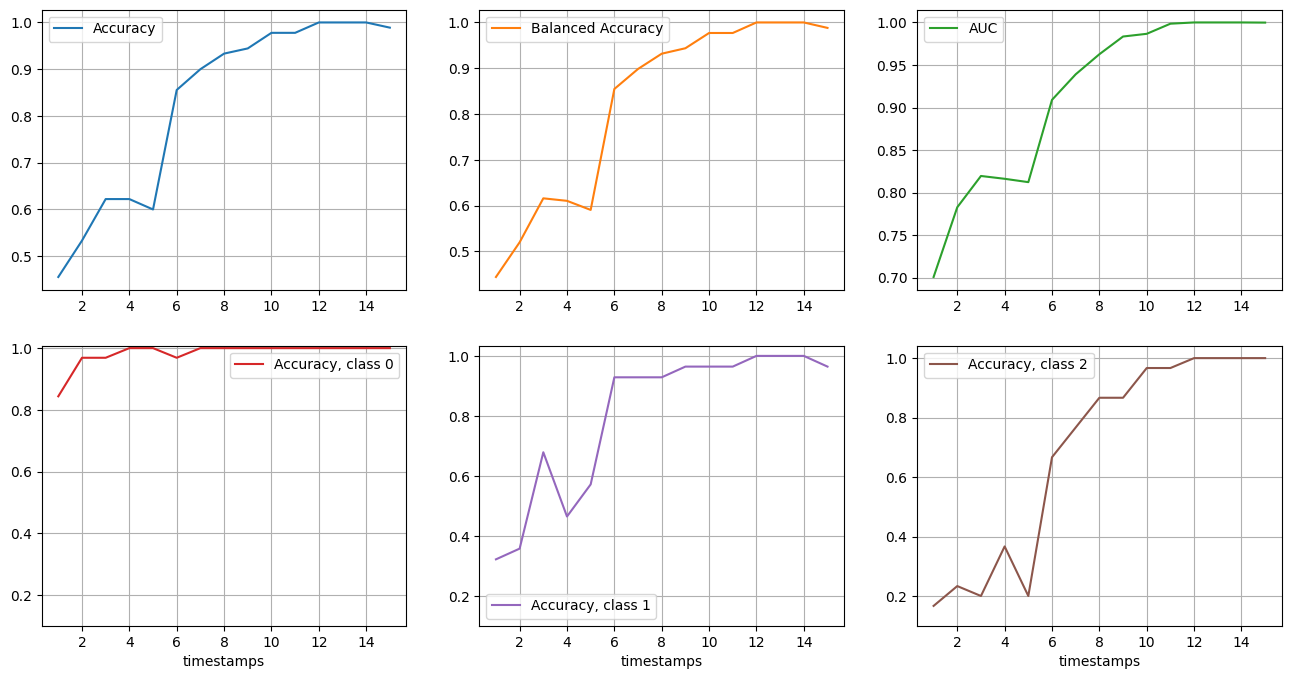

In [9]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusion_matrix

accuracies = [collection_clf.score(X_test[:, :l], y_test) for l in timestamps]

aucs = []
for l in timestamps:
    probas = collection_clf.predict_proba(X_test[:, :l]) if len(classes) > 2 else collection_clf.predict_proba(X_test[:, :l])[:,1]
    aucs.append(roc_auc_score(y_test, probas, multi_class="ovr"))

balanced_acc = [balanced_accuracy_score(y_test, collection_clf.predict(X_test[:, :l])) for l in timestamps]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,8))

colors = itertools.cycle(plt.cm.tab10.colors)
axes[0][0].plot(timestamps, accuracies, c=next(colors), label="Accuracy")
axes[0][1].plot(timestamps, balanced_acc, c=next(colors), label="Balanced Accuracy")
axes[0][2].plot(timestamps, aucs, c=next(colors), label="AUC")

# get intra class accuracy
confusion_matrices = [confusion_matrix(y_test, collection_clf.predict(X_test[:, :l])) for l in timestamps]
acc_scores = [confusion_matrices[i].diagonal() / confusion_matrices[i].sum(axis=1) for i in range(len(timestamps))]
acc_scores = np.array(acc_scores)

for i, cls in enumerate(classes):
    axes[1][i].plot(timestamps, acc_scores[:,i], c=next(colors), label=f"Accuracy, class {cls}")
    axes[1][i].set_ylim(0.1)
    axes[1][i].set_xlabel("timestamps")

for row in axes:
    for ax in row: 
        ax.grid()
        ax.legend()
plt.show()

That's seems pretty nice, performances are globally bad, even if slowly increasing, within the first 1/3 of the serie.

After this point is passed, a significant increase occurs and continue to get better up to 2/3 of the time series, nearly reaching 100% accuracy. 

Finally the last 1/3 of the series seems pretty useless.

### Step 3 Define a Trigger Model 

Last but not the least, we'll now need to build a trigger model, whose role is, based on predictions given by the classifier(s) defined previously, will decide wether one should accept this prediction and trigger the prediction or decline it and ask for more measurements.

For now, let's use the most simple trigger model one can think of : the `ProbabilityThreshold`: simply consisting setting a decision threshold above which a prediciton is triggered.

This threshold can be set manually, or can be learned by grid-search, such that *AvgCost* is minimized.

In [10]:
from ml_edm.trigger import ProbabilityThreshold, StoppingRule

proba_threshold = StoppingRule(timestamps)
print(proba_threshold.get_params())

{'n_jobs': 1, 'objective': 'avg_cost', 'stopping_rule': 'SR1', 'timestamps': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])}


### Step 4 : get it together 

Finally, we have now every ingredients to define our first `EarlyClassifier`

In [11]:
from ml_edm.early_classifier import EarlyClassifier

# we have already fit our classification module,
# prefit boolean should be set to True in this case 
early_clf = EarlyClassifier(
    chronological_classifiers=collection_clf, 
    trigger_model=proba_threshold, 
    cost_matrices=cost_matrices,
    prefit_classifiers=True
)
early_clf.fit(X_trigger, y_trigger)

EarlyClassifier(chronological_classifiers=ClassifiersCollection(base_classifier=Pipeline(steps=[('splinetransformer',
                                                                                                 SplineTransformer()),
                                                                                                ('calibratedclassifiercv',
                                                                                                 CalibratedClassifierCV(estimator=RidgeClassifierCV(),
                                                                                                                        method='isotonic'))]),
                                                                classifiers=[CalibratedClassifierCV(cv='prefit',
                                                                                                    estimator=Pipeline(steps=[('splinetransformer',
                                                                                                                               SplineTransforme...
                                                                                                                              ('calibratedclassifiercv',
                                                                                                                               CalibratedClassifierCV(estimator=RidgeClassifierCV(),
                                                                                                                                                      method='isotonic'))]))],
                                                                min_length=1,
                                                                timestamps=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])),
                cost_matrices=<ml_edm.cost_matrices.CostMatrices object at 0x7f60acea6fd0>,
                prefit_classifiers=True,
                trigger_model=StoppingRule(timestamps=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])))

### Final step : Evaluating your first `EarlyClassifier`

A good first step to analyse our ECTS algorithm is to call the `score()` function.

This custom score function has to takes as input series of same length, as it progressively unveil the series and provide data to our pipeline, until a prediction has been trigger.

The `return_metrics` boolean allows you, when set to `True`, to access a more comprehensive set of metrics, let's try it out !

In [12]:
results_dict = early_clf.score(X_test, y_test, return_metrics=True)

accuracy = results_dict['accuracy']
earliness = results_dict['earliness']
avg_cost = results_dict['average_cost']
hm = results_dict['harmonic_mean']

print(
    f"Accuracy : {accuracy:.4f} \n ", 
    f"Earliness : {earliness:.4f} \n ", 
    f"Average Cost : {avg_cost:.4f} \n ", 
    f"Harmonic Mean : {hm:.4f} \n ", 
)

Accuracy : 0.8556 
  Earliness : 0.3341 
  Average Cost : 0.2393 
  Harmonic Mean : 0.7489 
 


*AvgCost* metric may be the best evaluation metric when comparing trigger models, still it does not provide us many interpretable analysis.

Additionaly, *Accuracy* and *Earliness* are useful results we may want to compute to analyse qualitatively our ECTS models.

Here, our ECTS model trigger a prediction after seeing, on average, 25% of the time series. 78% of those predictions are correct predictions.

*Harmonic Mean* is a classic way of aggregating the two objectives. 

Vizualisation is also a nice way of analysing our models behaviors, let's try to create one informative plot :

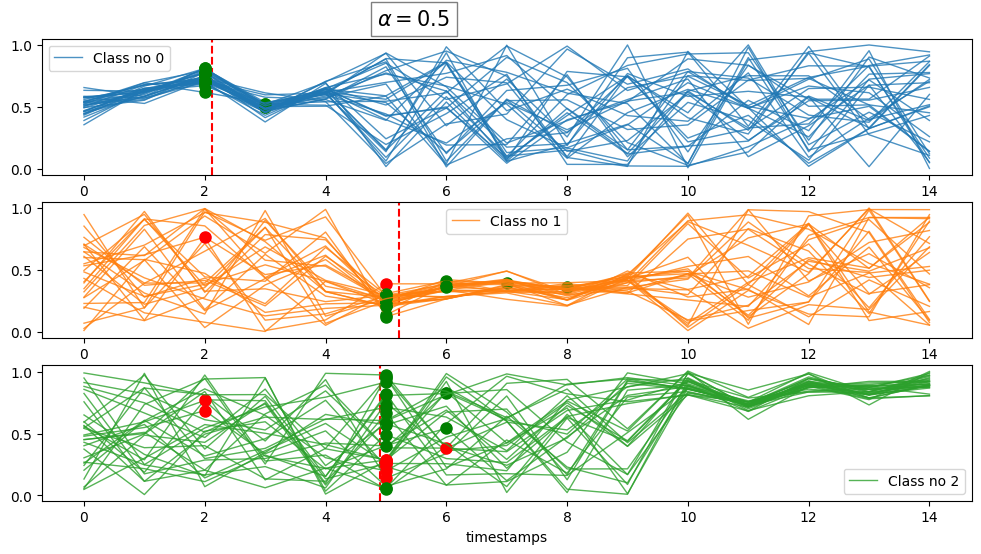

In [13]:
# plot distrib of trigger moments

def plot_trigger(results, axes):
    colors = itertools.cycle(plt.cm.tab10.colors)
    
    mean_preds, preds = [], []
    for i, cls in enumerate(classes):
        triggers_c = results['t_star'][y_test==cls]
        preds_c = results['pred_t_star'][y_test==cls]
        series_c = X_test[y_test==cls]

        c = next(colors)
        mean_preds.append(axes[i].axvline(np.mean(triggers_c)-1, ls="--", c="red"))
        pred_cls = []
        #axes[i].hist(triggers_c-1, density=True, color="red", alpha=0.5)
        for j, serie in enumerate(series_c):
            cc = "green" if preds_c[j] == cls else "red"
            ts = axes[i].plot(serie, color=c, alpha=0.8, lw=1, 
                              label=f"Class no {cls}" if j == 0 else "")
            pred_cls.append(axes[i].plot(triggers_c[j]-1, serie[triggers_c[j].astype(int)-1], 
                                      marker="o", c=cc, ms=8))
            if j == 0:
                axes[i].legend()
        preds.append(pred_cls)

    plt.xlabel("timestamps")
    title = axes[0].text(0.4, 1.1, r"$\alpha = {}$".format(ALPHA), 
                         bbox={'facecolor':'w', 'alpha':0.5, 'pad':5}, 
                         transform=axes[0].transAxes, ha="center", fontsize=15)

    return (ts, mean_preds, preds, title)

_, axes = plt.subplots(nrows=len(classes), ncols=1, figsize=(12,6))
_ = plot_trigger(results_dict, axes)

This is pretty good !

However, it seems that with $\alpha = 0.5$, our model is pushed to predict a bit too early. Indeed, we would like our model to wait for 2-3 more measurements to make more good predicitons on class 2.

It's no a surprise as, within the default cost setting, the cost is the same whether you classifiy right all series at deadline or if you classify randomly using a third of the series for a 3 class problem, for example.

Maybe it's time to tune the $\alpha$ parameter, let's see how the model behavior evolve with respect to $\alpha$ values.

In [14]:
def train_early_classifier(alpha, clf, trigger):

    cost_matrices = CostMatrices(
        timestamps=timestamps, 
        n_classes=len(classes), 
        alpha=alpha
    )
    
    # define early classifier 
    early_clf = EarlyClassifier(
        chronological_classifiers=clf, 
        trigger_model=trigger, 
        cost_matrices=cost_matrices, 
        prefit_classifiers=True
    )   
    early_clf.fit(X_trigger, y_trigger)

    return early_clf.score(X_test, y_test, return_metrics=True)

In [15]:
import matplotlib.animation as anim
from IPython.display import HTML
from warnings import filterwarnings

filterwarnings("ignore")

fi, ax = plt.subplots(nrows=len(classes), ncols=1, figsize=(12,6))

alphas = np.linspace(0, 1, 10)
res = dict.fromkeys(alphas)

for i, alph in enumerate(alphas):
    trigger = ProbabilityThreshold(timestamps)
    res[alph] = train_early_classifier(alph, collection_clf, trigger)
    
    if i == 0: # generate first frame of the animation 
        ts, mean_preds, points, title = plot_trigger(res[alph], ax)
        plt.close()

# function that uptade trigger points on the animation 
def update(frame):
    alph = alphas[frame]
    metrics = res[alph]
    
    for i, cls in enumerate(classes):
        triggers_cls = metrics['t_star'][y_test==cls]
        preds_cls = metrics['pred_t_star'][y_test==cls]
        
        mean_preds[i].set_xdata(np.mean(triggers_cls-1))
        for j, serie in enumerate(X_test[y_test == cls]):
            cc = "green" if preds_cls[j] == cls else "red"

            points[i][j][0].set_xdata(triggers_cls[j]-1)
            points[i][j][0].set_ydata(serie[triggers_cls[j].astype(int)-1])
            points[i][j][0].set_color(cc)

    preds = [line[0] for lines in points for line in lines]
    title.set_text(r"$\alpha = {:.3f}$, accuracy = {:.4f}, earliness = {:.4f}" 
        .format(alph, metrics['accuracy'], metrics['earliness']))

    return mean_preds + preds + [title]

ani = anim.FuncAnimation(fi, func=update, frames=len(alphas),
                         interval=900, blit=True, repeat_delay=1000)
HTML(ani.to_html5_video())

Here, one can clearly see how the $\alpha$ parameter is influencing the *Earliness* vs *Accuracy* trade-off : when $\alpha$ becomes large enough, the cost of triggering a decision later on the series becomes less significant in front of the information gain we'll have, reaching one third of serie in a first time and then two third when $\alpha$ approaches 1.

Yet, as this threshold model remains very simple it is not very flexible : the mean trigger moments are quite similar for each class. \
(One don't need to wait for half of the series to make a good prediction on class 0 for example.)

### Epilogue : let's now try another trigger model !

Until there, our triggering strategy has remain very simple : that is, a single threshold monitoring the $\max \hat{p}(y|X)$ outputed by our classifiers.

However, other triggering strategy are available in the `ml_edm` library.

ECONOMY-$\gamma$ is one of them, it has the nice property of being non myopic, i.e. try to anticipate the likely future, let's try it now.

In [16]:
from ml_edm.trigger import EconomyGamma

economy = EconomyGamma(timestamps)
print(economy.get_params())

{'aggregation_function': 'max', 'n_jobs': 1, 'nb_intervals': None, 'split_k': None, 'timestamps': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])}


In [17]:
res_extended  = {"Proba_threshold": res, "Economy": dict.fromkeys(alphas)}

for i, alpha in enumerate(alphas):
    res_extended["Economy"][alpha] = train_early_classifier(alpha, collection_clf, economy)

print(
    "\t AVERAGE COST RESULTS : \n\n",
    "Proba_threshold \t" + r"Economy-gamma" + "\n",
    "-"*50 + "\n",
)
for a in alphas:
    print(
        f"   {res_extended['Proba_threshold'][a]['average_cost']:.4f} \t\t "
        f" {res_extended['Economy'][a]['average_cost']:.4f}  \t\t "
        f" alpha = {a:.4f} \n",
        "-"*65
    )

	 AVERAGE COST RESULTS : 

 Proba_threshold 	Economy-gamma
 --------------------------------------------------

   0.0667 		  0.0667  		  alpha = 0.0000 
 -----------------------------------------------------------------
   0.1192 		  0.1198  		  alpha = 0.1111 
 -----------------------------------------------------------------
   0.1677 		  0.1728  		  alpha = 0.2222 
 -----------------------------------------------------------------
   0.2168 		  0.2244  		  alpha = 0.3333 
 -----------------------------------------------------------------
   0.2420 		  0.2243  		  alpha = 0.4444 
 -----------------------------------------------------------------
   0.2368 		  0.2107  		  alpha = 0.5556 
 -----------------------------------------------------------------
   0.1970 		  0.1590  		  alpha = 0.6667 
 -----------------------------------------------------------------
   0.1491 		  0.1165  		  alpha = 0.7778 
 -----------------------------------------------------------------
   0.0857 		  0.

As we can see, $Economy$-$\gamma$ seems to be better that $Proba\_threshold$ as soon as $\alpha$ get higher than $0.4$.

Otherwise, the two trigger stategies seems similar in term of $Avg\_Cost$.

In order to obtain more insights when comparing the two trigger models, one can plot a Pareto front.

In [18]:
# plot Pareto front 
def plot_pareto_front(results, alphas, axes):

    colors = itertools.cycle(plt.cm.tab10.colors)

    for res_dict in results: 

        color = next(colors)
        earliness, accuracies = [], []

        for a, alpha in  enumerate(alphas):
            earl = results[res_dict][alpha]['earliness']
            acc = results[res_dict][alpha]['accuracy']

            earliness.append(earl)
            accuracies.append(acc)

            label = str(res_dict) if a == 0 else ""        
            axes.plot(earl, acc, c=color, label=label,
                      marker="d", ms=10)

            if a == 0:
                axes.legend()

            if alpha == alphas[-2]:
                axes.plot(earl, acc, marker="d", c="red", ms=9,
                          mfc="r", mew=0.5, zorder=100)
        
        axes.plot(earliness, accuracies, ls="--", c=color)

    axes.text(results[res_dict][alphas[-2]]['earliness']+1e-1, 
                results[res_dict][alphas[-2]]['accuracy']-1e-1, 
                r"$\alpha = {:.3f}$".format(alphas[-2]), fontsize=15, c="red")
    
    return axes   

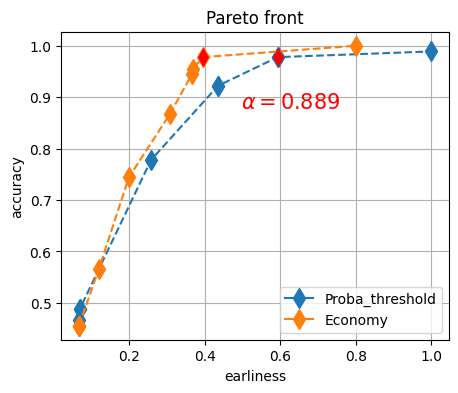

In [19]:
fig, axes = plt.subplots(figsize=(5,4))
plt.grid()
plt.xlabel("earliness")
plt.ylabel("accuracy")
plt.title("Pareto front")
axes = plot_pareto_front(res_extended, alphas, axes)

As we can see in the Pareto front, the $Economy$-$\gamma$ mehtod seems to be better performing over all possible values of $\alpha$.

For small $\alpha$, we can see that $Economy$-$\gamma$ adapts itself faster than $Proba\_threshold$, for which the *Earliness* vs *Accuracy* compromise stays almost constant for multiple values of $\alpha$.

For larger $\alpha$, it's worth noting that $Economy$-$\gamma$, has a tendency of being slightly earlier than $Proba\_threshold$, i.e. for a same $\alpha$ the point corresponding to $Economy$-$\gamma$ is more to the left on the $x$-axis, 

## One step further : trying to get closer to realistic setup

The default cost setting is oversimplistic and that probably promotes simple approaches.

Let's find out, by playing around with the `CostMatrices` parameters.

### Idea 1 : having an imbalanced misclassification cost

Now that all ingredients hace been introduced, one can try to play and test the models for more complex setting.

In the considered dataset, it will probably be fun to see what happens if the last class, i.e. the one for which the serie is completely random until it reaches two third of the serie, costs way more than other classes.

There are many applications which could correspond to this kind of set up, e.g. to anomaly detection.

In [20]:
# create new cost matrices 

cost_matrices_imbalanced = ...

In [ ]:
trigger_model = ProbabilityThreshold(timestamps)

early_clf = EarlyClassifier(
        chronological_classifiers=collection_clf, 
        trigger_model=trigger_model, 
        cost_matrices=cost_matrices_imbalanced, 
        prefit_classifiers=True
)
early_clf.fit(X_trigger, y_trigger)
res = early_clf.score(X_test, y_test, return_metrics=True)

print("Average cost : " + str(res["average_cost"]))
_, axes = plt.subplots(nrows=len(classes), ncols=1, figsize=(12,6))
_ = plot_trigger(res, axes)

### Idea 2 : having a stair-like delay cost

In [21]:
# create new cost matrices 
def delay(t):
    pass 
    
cost_matrices_stairs = ...

In [ ]:
trigger_model = ProbabilityThreshold(timestamps)

early_clf = EarlyClassifier(
        chronological_classifiers=collection_clf, 
        trigger_model=trigger_model, 
        cost_matrices=cost_matrices_stairs, 
        prefit_classifiers=True
)
early_clf.fit(X_trigger, y_trigger)
res = early_clf.score(X_test, y_test, return_metrics=True)

print("Average cost : " + str(res["average_cost"]))
_, axes = plt.subplots(nrows=len(classes)+1, ncols=1, figsize=(12,8))
_ = plot_trigger(res, axes)

points = np.linspace(1,timestamps[-1],1000) # just to make the stair spiky
axes[-1].plot(points-1, [delay(t) for t in points])
plt.show()

### Idea 3 : Costs shift between train and test 

Finallt, one could imagine that decision costs involved could suffer from a sudden shift due to multiple reasons, e.g. some deadline extension.

Those kind of situations emphasized how it could be beneficial for trigger methods to use the costs information during inference (*cost-aware at test*).

That is the case of the *Economy* method :

In [43]:
# create cost matrices for train 

cost_matrices_train = ...

# create different cost matrices for test

cost_matrices_test = ...

In [44]:
def eval_shift_test(trigger, cost_matrices_train, cost_matrices_test):

    early_clf = EarlyClassifier(
        chronological_classifiers=collection_clf, 
        trigger_model=trigger, 
        cost_matrices=cost_matrices_train, 
        prefit_classifiers=True
    )
    early_clf.fit(X_trigger, y_trigger)

    res = early_clf.score(X_test, y_test, return_metrics=True)
    print("Average cost with same train/test costs: " + str(res["average_cost"]))
    _, axes = plt.subplots(nrows=len(classes)+1, ncols=1, figsize=(12,8))
    _ = plot_trigger(res, axes)

    # cost matrices used for eval changes 
    early_clf.set_params(cost_matrices=cost_matrices_test)
    res = early_clf.score(X_test, y_test, return_metrics=True)
    print("Average cost with different train/test costs: " + str(res["average_cost"]))
    _, axes = plt.subplots(nrows=len(classes)+1, ncols=1, figsize=(12,8))
    _ = plot_trigger(res, axes)
    

In [ ]:
eval_shift_test(ProbabilityThreshold(timestamps), cost_matrices_stairs_train, cost_matrices_stairs_test)
plt.show()

In [ ]:
eval_shift_test(EconomyGamma(timestamps), cost_matrices_stairs_train, cost_matrices_stairs_test)
plt.show()